In [1]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import folktables
import numpy as np
import pickle
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
from bestLS_hindsight_together import *
from oridge_alwaysactive_implementable import *


from folktables.load_acs import state_list

In [40]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  N = len(Anh.cuml_regret_curve)
  for gnum in range(N):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end:.2f}, Anh end regret {Anh_end:.2f}, \n
    Anh better {Anhst} ''')
    print(f'''Oridge regret - Anh regret implementables {oridge_end - Anh_end}''')
    print(f'''Anh is {Anh_end / oridge_end} fraction of Oridge regret''')
    print(f'''Anh is {100 * (1 - (Anh_end / oridge_end))} % smaller than Oridge regret''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups') # caught a bug here!

In [3]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, TargetEncoder, StandardScaler, OneHotEncoder
def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def ordinal_encoder(df, cols): # similar to label encoder which only works for targets?
    '''
    Encode categorical into 0 ... n-1
    '''
    df_new = df.copy()
    ordinal_enc = OrdinalEncoder()
    df_new[cols] = ordinal_enc.fit_transform(df_new[cols])
    return df_new

def oh_sklearn(df, cols):
    pass
    # Issues with this operation as it doesnt preseve number of columns etc, the dummies method below works
    # df_new = df.copy()
    # oh_enc = OneHotEncoder()
    # df_new[cols] = oh_enc.fit_transform(df_new[cols])
    # return df_new

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def target_encoder(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new

def target_encoder2(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new, enc_auto

In [4]:
# Ira Globus code schema, and choosing only Significant features
ACSIncome = folktables.BasicProblem(
    features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'],
    target='PINCP',
    # target_transform=lambda x: x > 50000,    
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

cat_cols_sig = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'] # significant features from the earlier analysis

print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

for catg in cat_cols_sig:
    dataset[catg] = dataset[catg].astype(int)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [5]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
data_fil = data_incomeless200k
# top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
# data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

0.9625934030071766


In [6]:
print(cat_cols_sig)
df_oh = one_hot(data_fil, cat_cols_sig) # cat_cols_sig determined in 2buildmodels_withtargetencoding
print(df_oh.shape)

gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']
# A_tdf = df_oh[gnames]
# A_tdf['alwayson'] = 1
# A_t = A_tdf.to_numpy()

['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P']
(1569188, 910)


In [7]:
A_t = np.load('./onehot_encoded/nparrays/A_t12groups.npy')

In [8]:
df_oh = df_oh.drop(cat_cols_sig, axis=1)

In [9]:
df_oh_scaled = numeric_scaler(df_oh, df_oh.columns)
# del df_oh

In [17]:
# df_oh_scaled.to_pickle('./onehot_encoded/dataframes/df_oh_scaled_includes_sensitive')

In [10]:
df_oh_scaled

,WKHP,AGEP,PINCP,OCCP_10,OCCP_20,OCCP_40,OCCP_51,OCCP_52,OCCP_60,OCCP_101,...,MAR_5,RAC1P_1,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9
0,0.295918,0.025316,0.039472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.397959,0.037975,0.030967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.173469,0.025316,0.030467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.051020,0.215190,0.053479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.091837,0.025316,0.009455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,0.397959,0.291139,0.399670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1630163,0.397959,0.379747,0.299615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1630164,0.397959,0.367089,0.092501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1630165,0.295918,0.063291,0.060483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# First we build the best sq loss for each group, using bestLShindsight together

- first on the **undropped** race and sex columns **df_te_scaled** is used 

In [11]:
N = A_t.shape[1] #  12 groups 11 + 1 always active
# d = df_oh_scaled.shape[1] # d uses all 15 columns
# T = df_oh_scaled.shape[0] # ~1.5 million points
# print(N, d, T)

X_dat_oh_scaled = df_oh_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_oh_scaled = pd.DataFrame(df_oh_scaled['PINCP']) # picking up only the income column for the target

print(X_dat_oh_scaled.shape, y_dat_oh_scaled.shape)


12 898 1569188
(1569188, 897) (1569188, 1)


In [46]:
for ele in X_dat_oh_scaled_dropped.columns:
    if '_' not in ele:
        print(ele)

WKHP
AGEP
SEX
RAC1P


In [14]:
data_fil.shape

(1569188, 15)

# best square loss undropped

In [26]:
bls_undropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_undropped.update(A_t[t], X_dat_oh_scaled.iloc[[t]], y_dat_oh_scaled.iloc[t])

100%|██████████| 1569188/1569188 [38:32<00:00, 678.64it/s]  


In [27]:
bls_undropped.make_all_numpyarr()
import joblib
joblib.dump(bls_undropped, './onehot_encoded/models/bestsqloss/bls_oh_undropped.pkl')

['./onehot_encoded/models/bestsqloss/bls_oh_undropped.pkl']

# best square loss dropped bug 
- (earlier didnt drop SEX, RAC1P, dt_temp was not inplace, now explciity)

In [8]:
# preparing the data to be ded into bls_dropped object
df_temp = data_fil.copy()
df_temp = df_temp.drop(['SEX', 'RAC1P'] , axis = 1) # remove RACE and SEX columns before one-hot encoding

cat_cols_dropped = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'RELSHIPP', 'POBP', 'ENG', 'MAR']
df_oh = one_hot(df_temp, cat_cols_dropped) # cat_cols_sig determined in 2buildmodels_withtargetencoding
print(df_oh.shape)

df_oh = df_oh.drop(cat_cols_dropped, axis=1)

print(df_oh.shape)

df_oh_dropped_scaled = numeric_scaler(df_oh, df_oh.columns) # does min max scaling

# df_oh_dropped_scaled.to_pickle('./onehot_encoded/dataframes/df_oh_scaled_drops_sensitive')

(1569188, 897)
(1569188, 887)


In [9]:
X_dat_oh_scaled_dropped = df_oh_dropped_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_oh_scaled_dropped = pd.DataFrame(df_oh_dropped_scaled['PINCP']) # picking up only the income column for the target

In [16]:
# N = A_t.shape[1] #  12 groups 11 + 1 always active
# d = df_oh_dropped_scaled.shape[1] # d uses all 15 columns
# T = df_oh_dropped_scaled.shape[0] # ~1.5 million points

# print(N, d, T)

12 889 1569188


In [17]:
bls_dropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_dropped.update(A_t[t], X_dat_oh_scaled_dropped.iloc[[t]], y_dat_oh_scaled_dropped.iloc[t])

  0%|          | 0/1569188 [00:00<?, ?it/s]

100%|██████████| 1569188/1569188 [35:28<00:00, 737.14it/s] 


In [19]:
import joblib
bls_dropped.make_all_numpyarr()
joblib.dump(bls_dropped, './onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl')

['./onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl']

# Anh undropped

In [15]:
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_undropped = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_undropped.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_undropped.update_metaexps_loss(A_t[t], X_dat_oh_scaled.iloc[[t]], y_dat_oh_scaled.iloc[t]) # update internal states of the meta-experts

100%|██████████| 1569188/1569188 [38:37<00:00, 676.98it/s]


In [48]:
import joblib
bls_undropped = joblib.load('./onehot_encoded/models/bestsqloss/bls_oh_undropped.pkl')

In [25]:
joblib.dump(Anh_undropped, './onehot_encoded/models/Anh/Anh_undropped_15col_compact.pkl')

['./onehot_encoded/models/Anh/Anh_undropped_15col_compact.pkl']

In [47]:
Anh_undropped = joblib.load('./onehot_encoded/models/Anh/Anh_undropped_15col_compact.pkl')

In [50]:
bls_undropped.get_cumbestsqloss()

In [ ]:
# bls_undropped.get_cumbestsqloss()
# Anh_undropped.build_cumloss_curve(bls_undropped.best_sqloss, A_t)
# Anh_undropped.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved

In [51]:
or_implementable_undropped = joblib.load('./onehot_encoded/models/oridge_implementable/oridge_undropped15colsoh.pkl')
or_implementable_undropped.fill_subsequence_regrets(A_t, bls_undropped.best_sqloss)

Group number 0, Tg is 805503 

    oridge end regret 9801.24, Anh end regret 9178.31, 

    Anh better Yes 
Oridge regret - Anh regret implementables 622.9339959178469
Anh is 0.9364433744166862 fraction of Oridge regret
Anh is 6.355662558331376 % smaller than Oridge regret


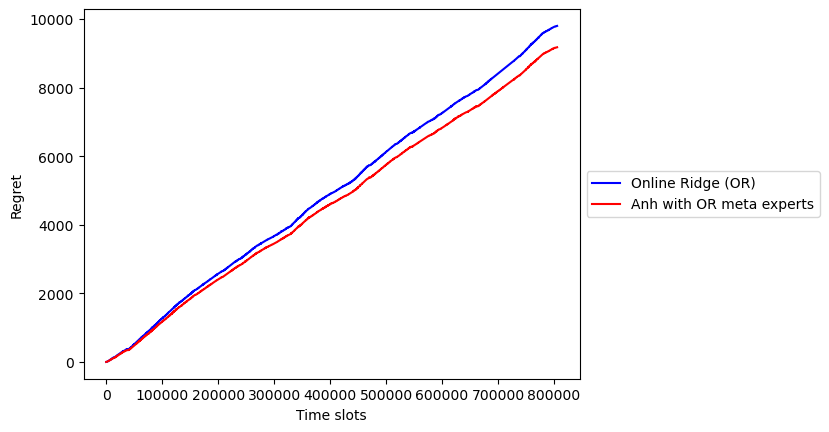

Group number 1, Tg is 763685 

    oridge end regret 8097.96, Anh end regret 7929.02, 

    Anh better Yes 
Oridge regret - Anh regret implementables 168.93882471104735
Anh is 0.9791380886832813 fraction of Oridge regret
Anh is 2.086191131671866 % smaller than Oridge regret


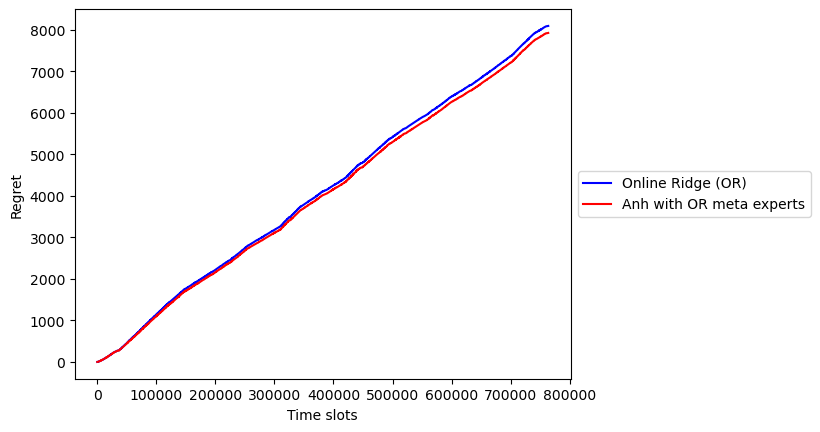

Group number 2, Tg is 1045807 

    oridge end regret 12542.05, Anh end regret 12133.35, 

    Anh better Yes 
Oridge regret - Anh regret implementables 408.7000413876376
Anh is 0.9674136100024487 fraction of Oridge regret
Anh is 3.2586389997551257 % smaller than Oridge regret


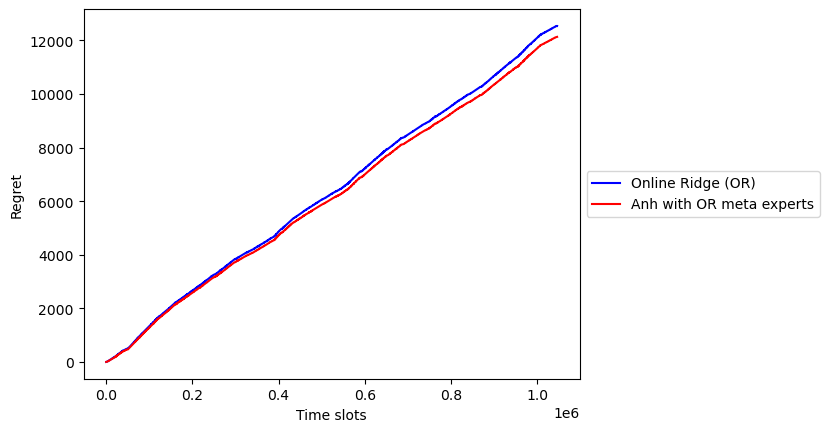

Group number 3, Tg is 136227 

    oridge end regret 962.25, Anh end regret 938.28, 

    Anh better Yes 
Oridge regret - Anh regret implementables 23.97295549287628
Anh is 0.9750866568450466 fraction of Oridge regret
Anh is 2.4913343154953416 % smaller than Oridge regret


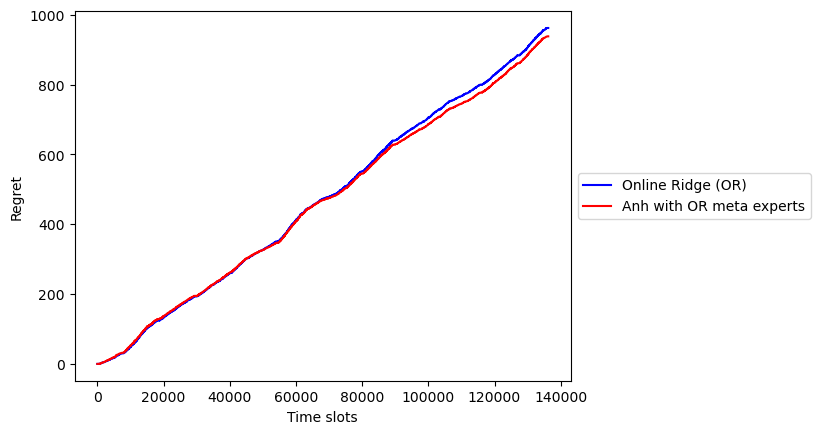

Group number 4, Tg is 14455 

    oridge end regret 78.68, Anh end regret 69.52, 

    Anh better Yes 
Oridge regret - Anh regret implementables 9.153321155377853
Anh is 0.8836604867106496 fraction of Oridge regret
Anh is 11.633951328935044 % smaller than Oridge regret


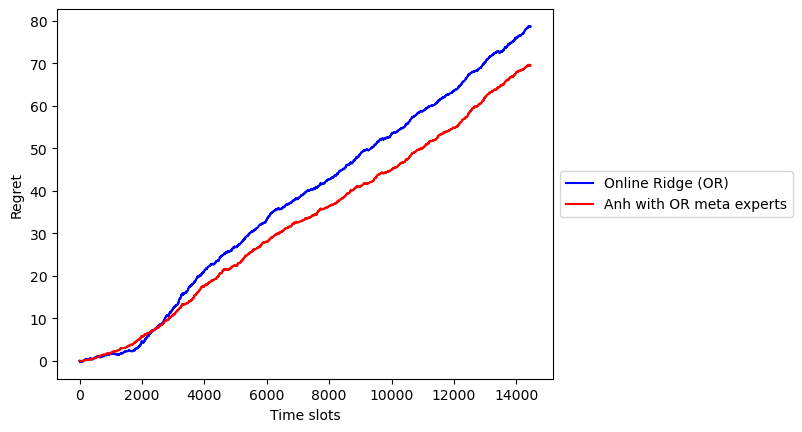

Group number 5, Tg is 726 

    oridge end regret 1.92, Anh end regret 1.36, 

    Anh better Yes 
Oridge regret - Anh regret implementables 0.5650496663156375
Anh is 0.7057820257340163 fraction of Oridge regret
Anh is 29.421797426598374 % smaller than Oridge regret


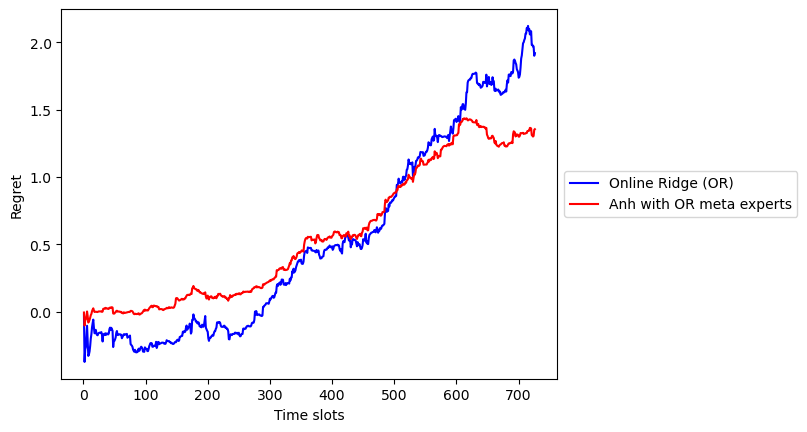

Group number 6, Tg is 2316 

    oridge end regret 12.14, Anh end regret 8.33, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.8128471664797985
Anh is 0.6859282783976242 fraction of Oridge regret
Anh is 31.407172160237586 % smaller than Oridge regret


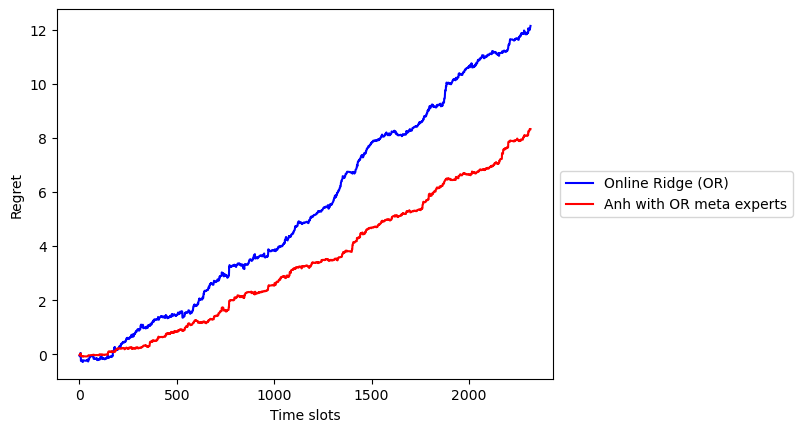

Group number 7, Tg is 100852 

    oridge end regret 1754.72, Anh end regret 1562.26, 

    Anh better Yes 
Oridge regret - Anh regret implementables 192.4675692582132
Anh is 0.8903145586033463 fraction of Oridge regret
Anh is 10.96854413966537 % smaller than Oridge regret


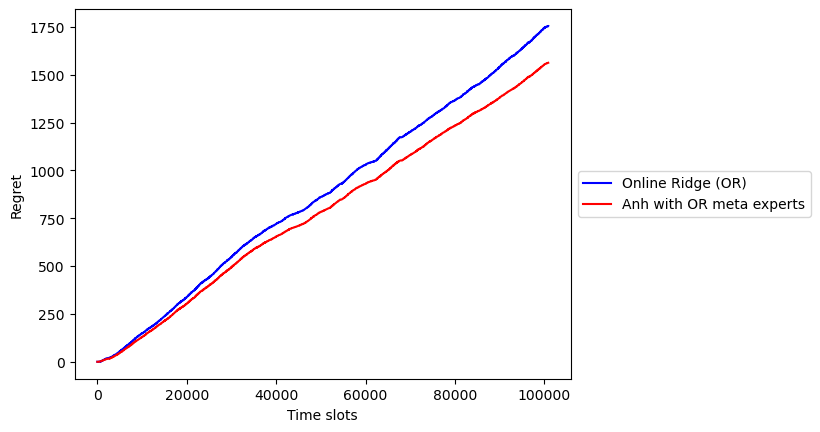

Group number 8, Tg is 2755 

    oridge end regret 10.95, Anh end regret 9.35, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.597722890299778
Anh is 0.8541105475639308 fraction of Oridge regret
Anh is 14.588945243606922 % smaller than Oridge regret


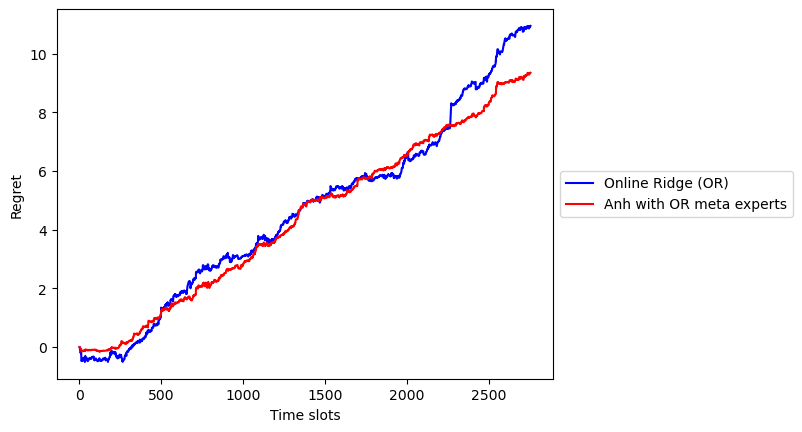

Group number 9, Tg is 97582 

    oridge end regret 724.65, Anh end regret 584.08, 

    Anh better Yes 
Oridge regret - Anh regret implementables 140.57511619733577
Anh is 0.8060103019215364 fraction of Oridge regret
Anh is 19.398969807846356 % smaller than Oridge regret


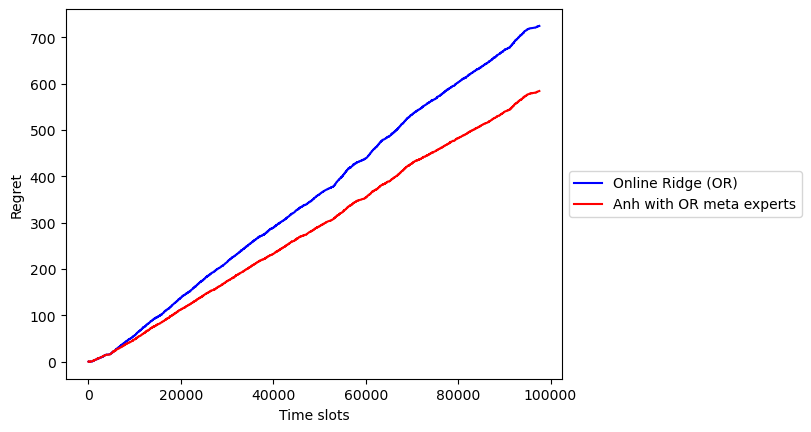

Group number 10, Tg is 168468 

    oridge end regret 1623.63, Anh end regret 1612.60, 

    Anh better Yes 
Oridge regret - Anh regret implementables 11.02819741415351
Anh is 0.9932076702625562 fraction of Oridge regret
Anh is 0.6792329737443814 % smaller than Oridge regret


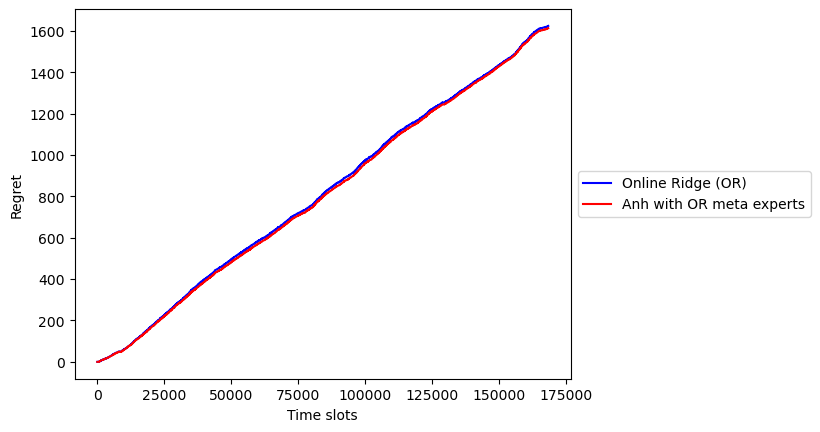

Group number 11, Tg is 1569188 

    oridge end regret 17702.74, Anh end regret 16910.87, 

    Anh better Yes 
Oridge regret - Anh regret implementables 791.8728206296291
Anh is 0.9552683463781321 fraction of Oridge regret
Anh is 4.473165362186792 % smaller than Oridge regret


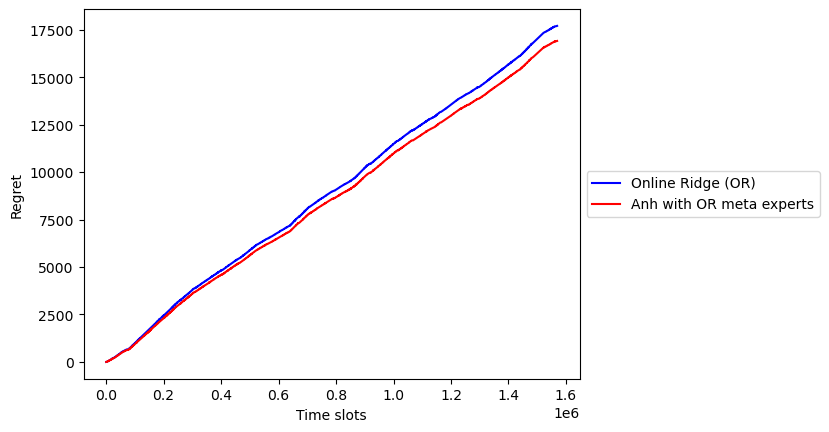

Anh better for 12 out of 12 groups


In [52]:
plot_ORidgevsAnh_together(or_implementable_undropped.cumreg_groupwise_oridge, Anh_undropped)

# Best squared loss dropped SEX, RAC1P.  

In [27]:
bls_dropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_dropped.update(A_t[t], X_dat_oh_scaled_dropped.iloc[[t]], y_dat_oh_scaled_dropped.iloc[t])

100%|██████████| 1569188/1569188 [37:57<00:00, 688.99it/s]  


In [28]:
bls_dropped.make_all_numpyarr()
import joblib
joblib.dump(bls_dropped, './onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl')

['./onehot_encoded/models/bestsqloss/bls_oh_dropped.pkl']

# Anh with dropped columns, TORUN

In [12]:
for ele in X_dat_oh_scaled_dropped.columns: #maybe make it into units tests into the future
    if '_' not in ele:
        print(ele)

WKHP
AGEP


In [20]:
X_dat_oh_scaled_dropped.shape, y_dat_oh_scaled_dropped.shape
N = A_t.shape[1]
T = A_t.shape[0]
print(N)
print(T, T == y_dat_oh_scaled_dropped.shape[0])

12
1569188 True


In [29]:
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_dropped = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_dropped.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_dropped.update_metaexps_loss(A_t[t], X_dat_oh_scaled_dropped.iloc[[t]], y_dat_oh_scaled_dropped.iloc[t]) # update internal states of the meta-experts

100%|██████████| 1569188/1569188 [40:28<00:00, 646.06it/s]


In [30]:
bls_dropped.get_cumbestsqloss()
Anh_dropped.build_cumloss_curve(bls_dropped.best_sqloss, A_t)
Anh_dropped.cleanup_for_saving() #compact size after cleanup, only essential external varaibles saved
joblib.dump(Anh_dropped, './onehot_encoded/models/Anh/Anh_dropped_15col_compact.pkl')

['./onehot_encoded/models/Anh/Anh_dropped_15col_compact.pkl']

# Buld the Implementable Oridge (always active), with dropped columns  V/S  Ada normal hedge with dropped columns

In [10]:
or_implementable_undropped = OnlineRidgeImplementable_alwaysactive(X_dat_oh_scaled, y_dat_oh_scaled) # undropped columns

100%|██████████| 1569188/1569188 [14:08<00:00, 1849.28it/s]


In [11]:
with open('./onehot_encoded/models/oridge_implementable/oridge_undropped15colsoh.pkl', 'wb') as f:
    pickle.dump(or_implementable_undropped, f)

In [31]:
# TODO Rerun with SEX, RAC1P bug which werent dropped
or_implementable_dropped = OnlineRidgeImplementable_alwaysactive(X_dat_oh_scaled_dropped, y_dat_oh_scaled_dropped) # dropped sensitive groups

  0%|          | 0/1569188 [00:00<?, ?it/s]

100%|██████████| 1569188/1569188 [14:45<00:00, 1772.40it/s]


In [32]:
with open('./onehot_encoded/models/oridge_implementable/oridge_dropped15colsoh.pkl', 'wb') as f:
    pickle.dump(or_implementable_dropped, f)

In [35]:
or_implementable_dropped.fill_subsequence_regrets(A_t, bls_dropped.best_sqloss)

In [ ]:
# Anh vs oridge(implementable) on dropped sensitive columns

Group number 0, Tg is 805503 

    oridge end regret 10770.92, Anh end regret 9329.17, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1441.7477769507823
Anh is 0.8661444402201409 fraction of Oridge regret
Anh is 13.385555977985907 % smaller than Oridge regret


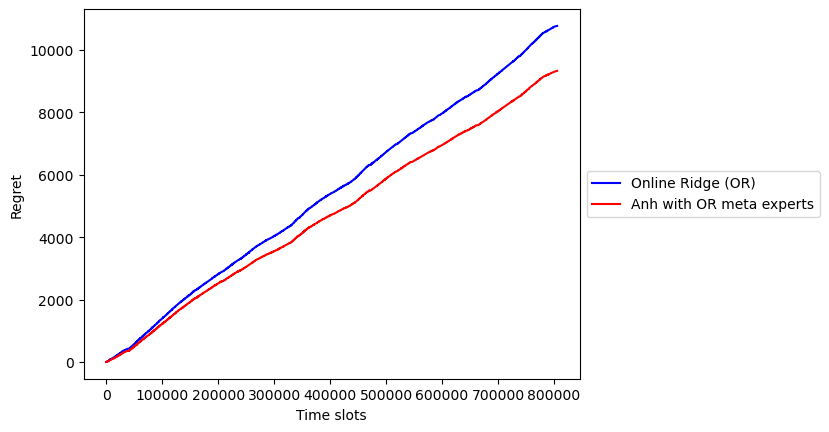

Group number 1, Tg is 763685 

    oridge end regret 8985.72, Anh end regret 8117.50, 

    Anh better Yes 
Oridge regret - Anh regret implementables 868.2264670583281
Anh is 0.903377128584371 fraction of Oridge regret
Anh is 9.662287141562897 % smaller than Oridge regret


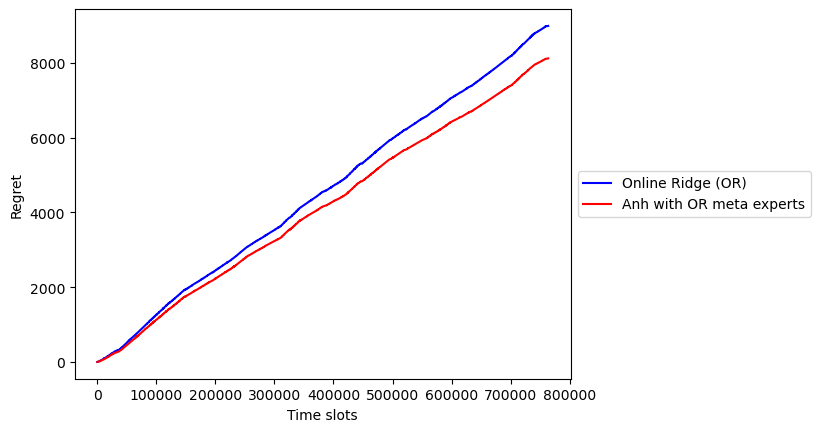

Group number 2, Tg is 1045807 

    oridge end regret 13334.93, Anh end regret 11819.21, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1515.724566834302
Anh is 0.8863342865745497 fraction of Oridge regret
Anh is 11.36657134254503 % smaller than Oridge regret


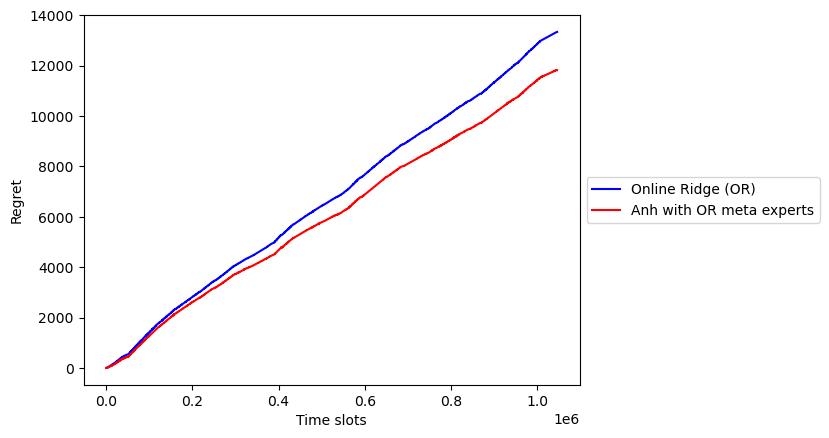

Group number 3, Tg is 136227 

    oridge end regret 1070.68, Anh end regret 938.21, 

    Anh better Yes 
Oridge regret - Anh regret implementables 132.46277420754723
Anh is 0.8762812218857838 fraction of Oridge regret
Anh is 12.371877811421616 % smaller than Oridge regret


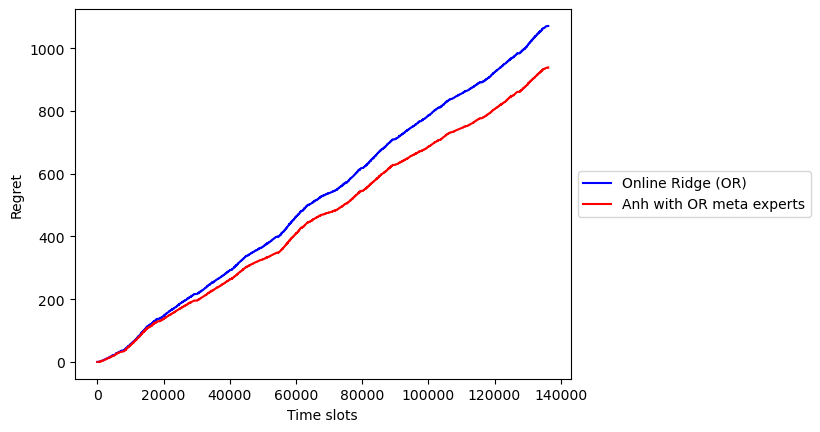

Group number 4, Tg is 14455 

    oridge end regret 91.08, Anh end regret 71.14, 

    Anh better Yes 
Oridge regret - Anh regret implementables 19.940422599143517
Anh is 0.7810749655348617 fraction of Oridge regret
Anh is 21.892503446513835 % smaller than Oridge regret


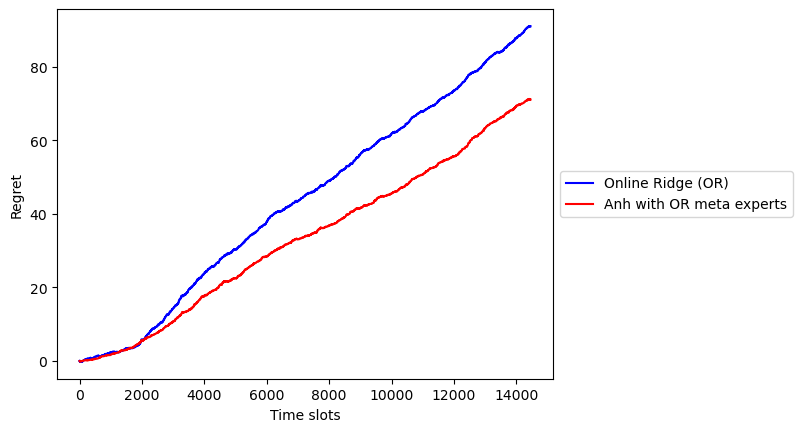

Group number 5, Tg is 726 

    oridge end regret 2.51, Anh end regret 1.24, 

    Anh better Yes 
Oridge regret - Anh regret implementables 1.270443331455283
Anh is 0.49321341463641794 fraction of Oridge regret
Anh is 50.6786585363582 % smaller than Oridge regret


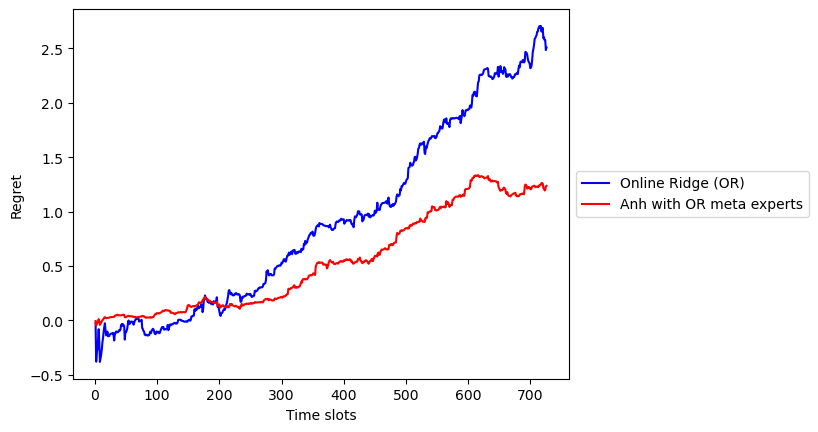

Group number 6, Tg is 2316 

    oridge end regret 13.67, Anh end regret 8.36, 

    Anh better Yes 
Oridge regret - Anh regret implementables 5.312326032019051
Anh is 0.6114815717075388 fraction of Oridge regret
Anh is 38.85184282924612 % smaller than Oridge regret


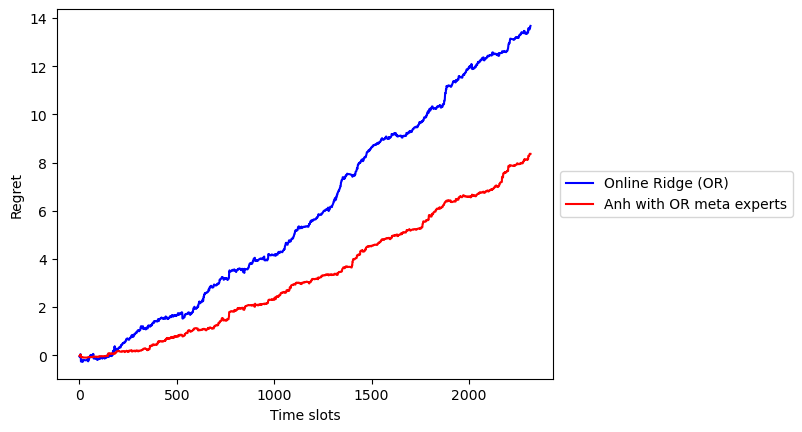

Group number 7, Tg is 100852 

    oridge end regret 1856.55, Anh end regret 1592.73, 

    Anh better Yes 
Oridge regret - Anh regret implementables 263.8157931625483
Anh is 0.8578996808744386 fraction of Oridge regret
Anh is 14.210031912556143 % smaller than Oridge regret


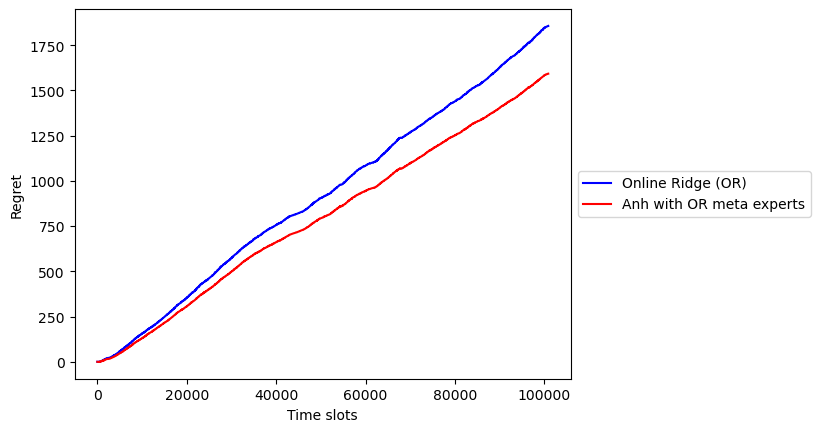

Group number 8, Tg is 2755 

    oridge end regret 13.24, Anh end regret 9.58, 

    Anh better Yes 
Oridge regret - Anh regret implementables 3.662208295300985
Anh is 0.7235009798136303 fraction of Oridge regret
Anh is 27.649902018636972 % smaller than Oridge regret


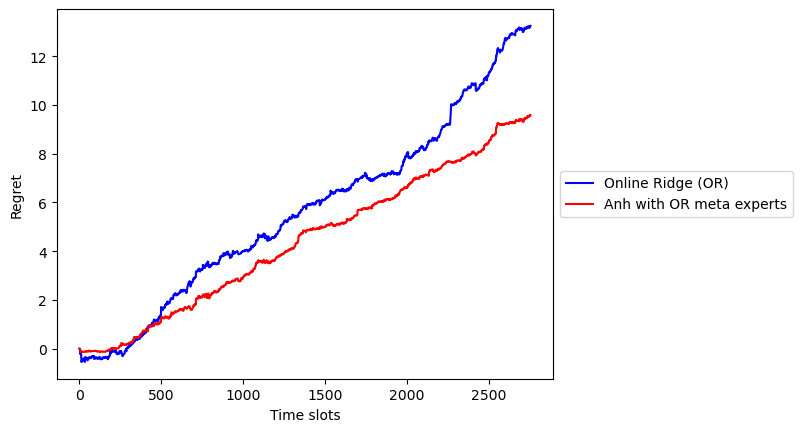

Group number 9, Tg is 97582 

    oridge end regret 860.35, Anh end regret 606.16, 

    Anh better Yes 
Oridge regret - Anh regret implementables 254.19354594474316
Anh is 0.7045470141430306 fraction of Oridge regret
Anh is 29.545298585696944 % smaller than Oridge regret


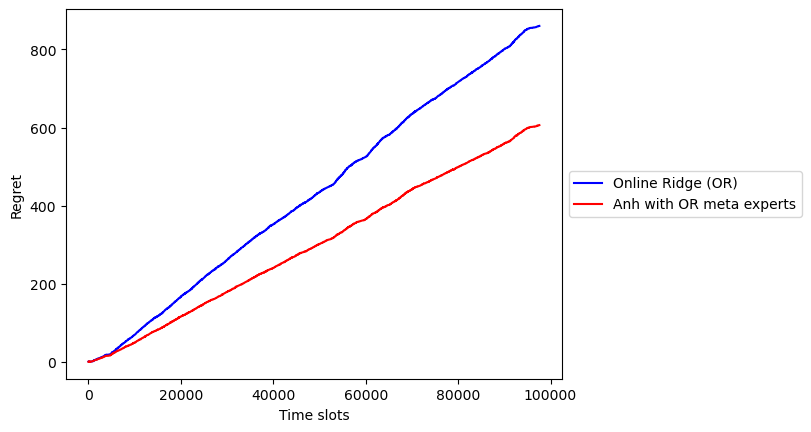

Group number 10, Tg is 168468 

    oridge end regret 1775.39, Anh end regret 1661.80, 

    Anh better Yes 
Oridge regret - Anh regret implementables 113.59216360115897
Anh is 0.9360186477291896 fraction of Oridge regret
Anh is 6.3981352270810365 % smaller than Oridge regret


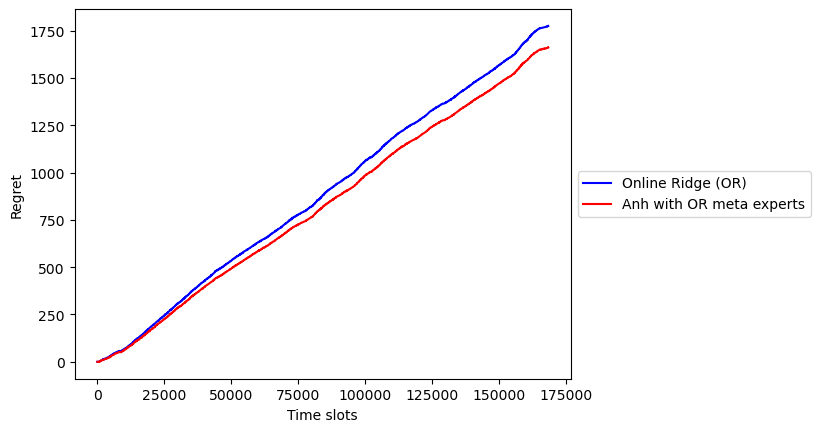

Group number 11, Tg is 1569188 

    oridge end regret 18981.55, Anh end regret 16671.58, 

    Anh better Yes 
Oridge regret - Anh regret implementables 2309.9742440092596
Anh is 0.8783042417499957 fraction of Oridge regret
Anh is 12.169575825000434 % smaller than Oridge regret


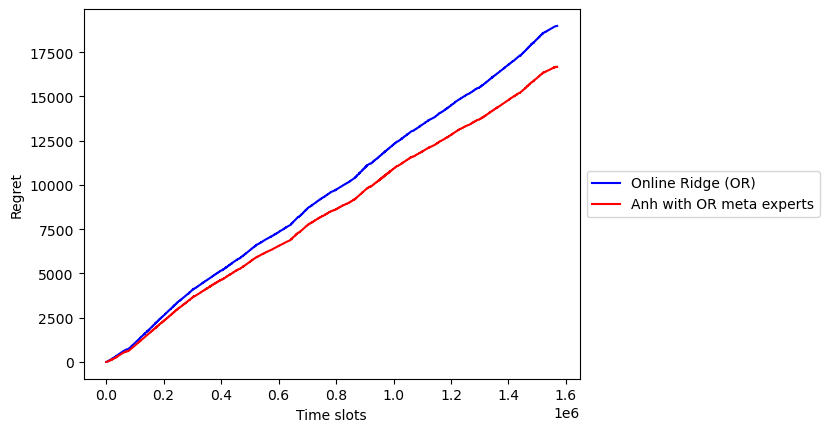

Anh better for 12 out of 12 groups


In [41]:
plot_ORidgevsAnh_together(or_implementable_dropped.cumreg_groupwise_oridge, Anh_dropped)